In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
path = '/content/drive/My Drive/kaggle/wheat/'
os.chdir(path) # カレントディレクトリを指定
os.getcwd()

'/content/drive/My Drive/kaggle/wheat'

In [ ]:
!!pip install kaggle

['Requirement already satisfied: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)',
 'Requirement already satisfied: python-dateutil in /usr/local/lib/python3.6/dist-packages (from kaggle) (2.8.1)',
 'Requirement already satisfied: tqdm in /usr/local/lib/python3.6/dist-packages (from kaggle) (4.41.1)',
 'Requirement already satisfied: requests in /usr/local/lib/python3.6/dist-packages (from kaggle) (2.23.0)',
 'Requirement already satisfied: urllib3<1.25,>=1.21.1 in /usr/local/lib/python3.6/dist-packages (from kaggle) (1.24.3)',
 'Requirement already satisfied: certifi in /usr/local/lib/python3.6/dist-packages (from kaggle) (2020.6.20)',
 'Requirement already satisfied: python-slugify in /usr/local/lib/python3.6/dist-packages (from kaggle) (4.0.0)',
 'Requirement already satisfied: six>=1.10 in /usr/local/lib/python3.6/dist-packages (from kaggle) (1.12.0)',
 'Requirement already satisfied: chardet<4,>=3.0.2 in /usr/local/lib/python3.6/dist-packages (from requests->kaggle) (3.0.

In [ ]:
!mkdir -p /root/.kaggle/
!cp /content/drive/"My Drive"/kaggle/config/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# competitions = api.competitions_list(category="featured")
# for comp in competitions:
#     print(comp.ref,comp.reward,comp.userRank,sep=',')

In [ ]:
import re
competitions = 'global-wheat-detection'

for json_dict in api.competitions_data_list_files(competitions):
  data_path = './input'
  name = json_dict['name']
  match = re.search(r'.*/', name)
  if match is not None:
    data_path = os.path.join(data_path, match.group())
  api.competition_download_file(competitions, name, data_path)

In [ ]:
!kaggle datasets download -d shonenkov/timm_efficientdet_pytorch ./timm-efficientdet-pytorch/

404 - Not Found


In [ ]:
import glob
import zipfile

def unzip(path):
  zip_files = glob.glob(f"{path}/**/*.zip")
  for file in zip_files:
    print(file)
    with zipfile.ZipFile(file) as existing_zip:
        existing_zip.extractall(path=os.path.dirname(file))

unzip(path)

/content/drive/My Drive/kaggle/wheat/input/train.csv.zip


In [4]:
!pip install timm==0.1.26
!pip install pycocotools==2.0
!pip install albumentations -U

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp36-cp36m-linux_x86_64.whl size=266429 sha256=c98c043ec9d40bc25692c3ef1713b09594dd674289a558b5b4771c870ab44406
  Stored in directory: /root/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1
     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 952kB 11.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=488be27d87a6a9d34c2fb60e7fa0f5049d79fbb19360d6daf4921ee8e95e1273
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installati

# Code

In [5]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch")
sys.path.insert(0, "./omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
DATA_DIR = './input'

In [6]:
marking = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
df_folds.head()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


In [8]:
# psuedo = pd.read_csv(os.path.join(DATA_DIR, 'psuedo_label_mod.csv'), index_col=0)
# psuedo['width'] = 1024
# psuedo['height'] = 1024
# psuedo['source'] = 'test'

# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, random_state=42, shuffle=True)

# df_folds2 = psuedo[['image_id']].copy().groupby('image_id').count()
# df_folds2.drop_duplicates(inplace=True)
# df_folds2.loc[:, 'fold'] = 0

# for fold_number, (train_index, val_index) in enumerate(kf.split(X=df_folds2.index)):
#     df_folds2.loc[df_folds2.iloc[val_index].index, 'fold'] = fold_number

# df_folds2.head()

In [9]:
# marking = pd.concat([marking, psuedo])
# marking = marking.reset_index(drop=True)
# marking.head()

In [10]:
# marking.tail()

In [11]:
# df_folds = pd.concat([df_folds2, df_folds])
# df_folds.head()

In [12]:
from albumentations.core.transforms_interface import ImageOnlyTransform
    
class InsectAugmentation(ImageOnlyTransform):
    """
    Impose an image of a insect to the target image
    -----------------------------------------------
    
    Author(s): Wei Hao Khoong
    Built-upon Roman's AdvancedHairAugmentation in Melanoma competition
    
    Args:
        insects (int): maximum number of insects to impose
        insects_folder (str): path to the folder with insects images
    """

    def __init__(self, insects=2, dark_insect=False, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.insects = insects
        self.dark_insect = dark_insect
        self.insects_folder = "./bee/"

    def apply(self, image, **kwargs):
        """
        Args:
            image (PIL Image): Image to draw insects on.

        Returns:
            PIL Image: Image with drawn insects.
        """
        n_insects = random.randint(1, self.insects) # for this example I put 1 instead of 0 to illustrate the augmentation
        
        if not n_insects:
            return image
        
        height, width, _ = image.shape  # target image width and height
        insects_images = [im for im in os.listdir(self.insects_folder) if 'png' in im]
        
        for _ in range(n_insects):
            insect = cv2.cvtColor(cv2.imread(os.path.join(self.insects_folder, random.choice(insects_images))), cv2.COLOR_BGR2RGB)
            insect = cv2.flip(insect, random.choice([-1, 0, 1]))
            insect = cv2.rotate(insect, random.choice([0, 1, 2]))

            h_height, h_width, _ = insect.shape  # insect image width and height
            roi_ho = random.randint(0, image.shape[0] - insect.shape[0])
            roi_wo = random.randint(0, image.shape[1] - insect.shape[1])
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask 
            img2gray = cv2.cvtColor(insect, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of insect in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of insect from insect image.
            if self.dark_insect:
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                insect_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                insect_fg = cv2.bitwise_and(insect, insect, mask=mask)

            # Put insect in ROI and modify the target image
            dst = cv2.add(img_bg, insect_fg, dtype=cv2.CV_64F)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return image 

In [13]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5), # 拡大
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9), # 色相、彩度の変更
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9), # 明るさとコントラストの変更
            ],p=0.9),
            A.ToGray(p=0.01), # 白黒変換
            A.HorizontalFlip(p=0.5), # 左右反転
            # A.VerticalFlip(p=0.5), # 上下反転
            A.Blur(blur_limit=30, p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.5),
            InsectAugmentation(insects=2, dark_insect=True, p=0.5),
            A.Resize(height=1024, width=1024, p=1),
            # A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5), # 正方形に一部データをdrop outさせる
            # A.CoarseDropout(max_holes=16, max_height=32, max_width=32, min_height=8, min_width=8, fill_value=0, p=0.5), # 矩形に一部データをdrop outさせる
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc', # [x_min, y_min, x_max, y_max]
            min_area=0, # 最小面積
            min_visibility=0, # 最小領域の割合
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [14]:
TRAIN_ROOT_PATH = os.path.join(DATA_DIR, 'train')

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False, mixup=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.mixup = mixup

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image_id = self.image_ids[index]
            num_boxes = len(self.marking[self.marking.image_id==image_id])
            if self.mixup and num_boxes < 20 and random.random() > 0.5:
              image, boxes = self.load_mixup_image_and_boxes(index)
            else:
              image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # 幅を座標(右端)に変換
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # 高さを座標(上端)に変換
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        多分YOLOv5みたいに切り分けてくっつけるやつ。
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

    def load_mixup_image_and_boxes(self, index, imsize=1024):
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1)) # 被らないだろう前提
        mixup_image = (image+r_image) / 2
        mixup_boxes = np.vstack([boxes, r_boxes])

        return mixup_image, mixup_boxes

In [15]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
    mixup=True
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
    mixup=False
)

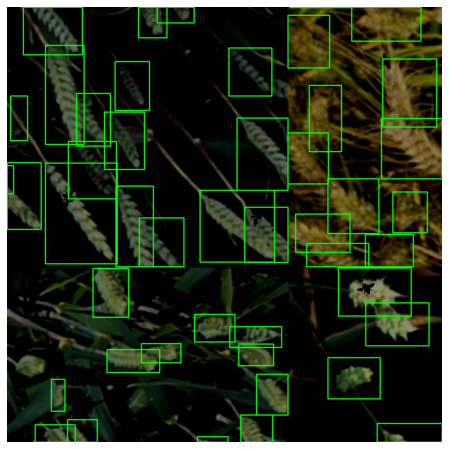

In [17]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [20]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 100 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix3'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [22]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=1024
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    # gc.collect()

    net = DetBenchTrain(net, config)
    net.eval();
    return net.cuda()

# your place of the model
net = load_net('./effdet5-cutmix-augmix3/last-checkpoint.bin')

In [23]:
# from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
# from effdet.efficientdet import HeadNet

# def get_net():
#     config = get_efficientdet_config('tf_efficientdet_d6')
#     net = EfficientDet(config, pretrained_backbone=False)
#     net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
#     checkpoint = torch.load('./effdet5-cutmix-augmix3/last-checkpoint.bin')
#     net.load_state_dict(checkpoint['model_state_dict'])
#     config.num_classes = 1
#     config.image_size = 1024
#     # net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
#     return DetBenchTrain(net, config)

# net = get_net()

In [ ]:
# argument追加, insect aug, 条件付きmixup20, d6, img_size1024
run_training()

Fitter prepared. Device is cuda:0

2020-08-04T03:05:30.468874
LR: 3.125e-06
[RESULT]: Train. Epoch: 0, summary_loss: 0.43740, time: 2699.41101
[RESULT]: Val. Epoch: 0, summary_loss: 0.42766, time: 132.17945

2020-08-04T03:52:47.944263
LR: 3.125e-06
[RESULT]: Train. Epoch: 1, summary_loss: 0.43499, time: 2575.74932
[RESULT]: Val. Epoch: 1, summary_loss: 0.43735, time: 130.31789

2020-08-04T04:37:57.657167
LR: 3.125e-06
[RESULT]: Train. Epoch: 2, summary_loss: 0.43677, time: 2578.78073
[RESULT]: Val. Epoch: 2, summary_loss: 0.43881, time: 130.22623

2020-08-04T05:23:09.726680
LR: 3.125e-06


In [ ]:
!ls

effdet5-cutmix-augmix  ensemble_boxes  omegaconf    timm-efficientdet-pytorch
efficientdet	       input	       __pycache__  yolov5_wheat


# Inference

In [ ]:
# import sys
# sys.path.insert(0, "./")


import ensemble_boxes
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

In [ ]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
def load_net_val(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net_val('./effdet5-cutmix-augmix/best-checkpoint-026epoch.bin')

In [ ]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [ ]:
def process_det(index, det, score_threshold=0.25):
    boxes = det[index].detach().cpu().numpy()[:,:4]    
    scores = det[index].detach().cpu().numpy()[:,4]
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    boxes = (boxes).clip(min=0, max=511).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores

In [ ]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [ ]:
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [ ]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple

@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
    mixup=False
)

def collate_fn(batch):
    return tuple(zip(*batch))

val_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
import matplotlib.pyplot as plt

for j, (images, targets, image_ids) in enumerate(val_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

TypeError: ignored

In [ ]:
results = []

for images, targets, image_ids in val_loader:
    predictions = make_tta_predictions(images)
    gt_boxes = [target['boxes'].to(self.device).float() for target in targets]
    preds = []
    scoress = []
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).round().astype(np.int32).clip(min=0, max=1023)

        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        preds.append(boxes)
        scoress.append(scores)

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)
    # for local validation
    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted = preds[preds_sorted_idx]
    validation_image_precision = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

    for idx, image in enumerate(images):
        image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')

        validation_image_precisions.append(image_precision)

print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

TypeError: ignored

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
# test_df.to_csv('submission.csv', index=False)
test_df.head()